Try the basic negative learning rule with threshold. Ideally, we want:
1. Neuron connections to themselves unmodified
2. Neurons firing similarily to strengthen connections between each other
3. Neurons firing dissimilarily to be unmodified

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nengo
from nengo.utils.matplotlib import rasterplot

from nengo_learn_assoc_mem.utils import meg_from_spikes
from nengo_learn_assoc_mem.learning_rules import rec_bcm

import importlib

In [34]:
importlib.reload(rec_bcm)

<module 'nengo_learn_assoc_mem.learning_rules.rec_bcm' from '/home/saubin/git/nengo_learn_assoc_mem/nengo_learn_assoc_mem/learning_rules/rec_bcm.py'>

In [2]:
def rec_legend(root, li):
    return [f"{root}$\\rightarrow${ll}" for ll in li]

def stim_func(t):
    if (t % 1) > 0.5:
        return 0.3
    else:
        return -0.3

In [3]:
dt = 0.001
seed = 0
pre_nrn = 4

ens_params = dict(encoders=[[1], [1], [-1], [-1]], intercepts=[-0.5, -0.1, -0.1, -0.5], max_rates=[250, 300, 300, 250])

# Baseline

In [38]:
rec_inhib = (-1*np.ones(pre_nrn) + np.eye(pre_nrn)) / 1e4

with nengo.Network() as base_model:
    stim = nengo.Node(stim_func)
    enabled = nengo.Node(1)

    ens = nengo.Ensemble(pre_nrn, 1, **ens_params)

    rec_net = rec_bcm.RecBCM(pre_nrn, rec_inhib, learning_rate=5e-6, threshold=120, max_inhib=-0.02)

    nengo.Connection(stim, ens, synapse=None)

    nengo.Connection(ens.neurons, rec_net.in_neurons, synapse=0.01)
    nengo.Connection(ens.neurons, rec_net.out_neurons, synapse=0.01)
    nengo.Connection(enabled, rec_net.enable, synapse=None)
    nengo.Connection(rec_net.output, ens.neurons, synapse=None)

    p_in = nengo.Probe(stim)
    p_spikes = nengo.Probe(ens.neurons)
    p_out = nengo.Probe(ens, synapse=0.01)

In [39]:
sim_len = 3
with nengo.Simulator(base_model) as sim:
    sim.run(sim_len)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


In [40]:
w_hist = np.array(rec_net.weight_history)
w_hist_trange = sim.trange(dt=0.1)

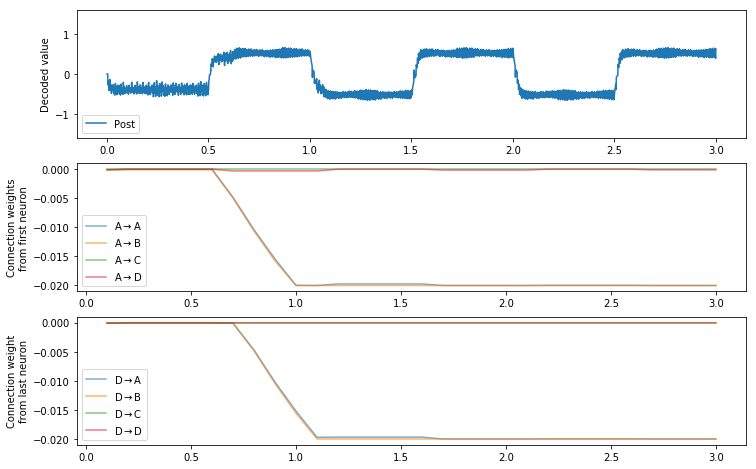

In [44]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

plt.subplot(3, 1, 2)
plt.plot(w_hist_trange, w_hist[:, 2], alpha=0.6)
plt.ylabel("Connection weights\nfrom first neuron")
plt.legend(rec_legend("A", ("A", "B", "C", "D")))

plt.subplot(3, 1, 3)
plt.plot(w_hist_trange, w_hist[:, -1], alpha=0.6)
plt.ylabel("Connection weight\nfrom last neuron")
plt.legend(rec_legend("D", ("A", "B", "C", "D")))

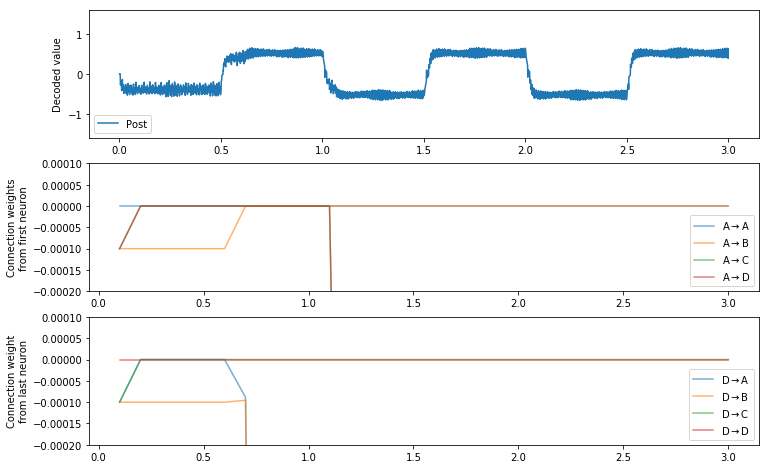

In [42]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

plt.subplot(3, 1, 2)
plt.plot(w_hist_trange, w_hist[:, 0], alpha=0.6)
plt.ylabel("Connection weights\nfrom first neuron")
plt.ylim(-2e-4, 1e-4)
plt.legend(rec_legend("A", ("A", "B", "C", "D")))

plt.subplot(3, 1, 3)
plt.plot(w_hist_trange, w_hist[:, -1], alpha=0.6)
plt.ylabel("Connection weight\nfrom last neuron")
plt.ylim(-2e-4, 1e-4)
plt.legend(rec_legend("D", ("A", "B", "C", "D")))

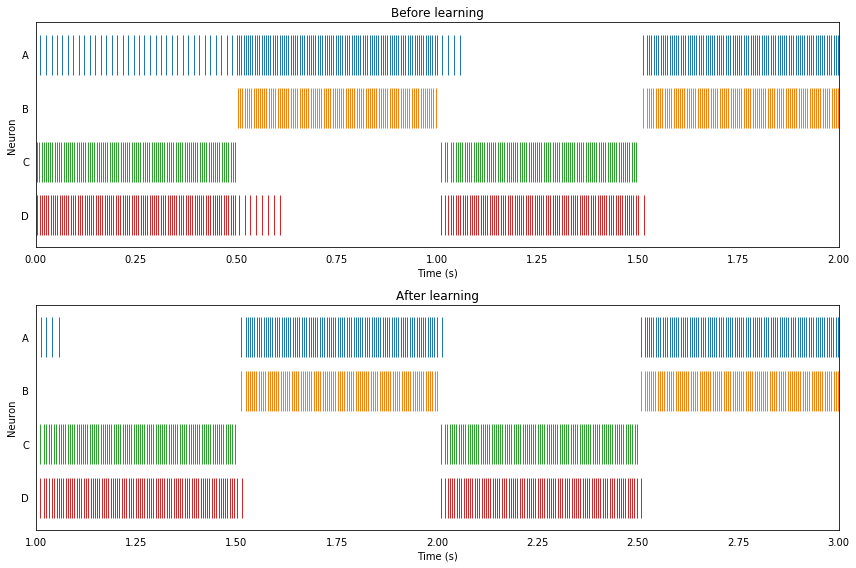

In [75]:
plt.figure(figsize=(12, 8))
win = int(2e3)

ax = plt.subplot(2, 1, 1)
rasterplot(sim.trange()[:win], sim.data[p_spikes][:win], ax)
ax.set_ylabel('Neuron')
ax.set_yticklabels(("A", "B", "C", "D"))
ax.set_xlabel('Time (s)')
ax.set_title('Before learning')

ax = plt.subplot(2, 1, 2)
rasterplot(sim.trange()[-win:], sim.data[p_spikes][-win:], ax)
ax.set_ylabel('Neuron')
ax.set_yticklabels(("A", "B", "C", "D"))
ax.set_xlabel('Time (s)')
ax.set_title('After learning')

plt.tight_layout()

# Remove threshold

A lower threshold can be managed with a lower learning rate

In [51]:
rec_inhib = (-1*np.ones(pre_nrn) + np.eye(pre_nrn)) / 1e4

with nengo.Network() as model:
    stim = nengo.Node(stim_func)
    enabled = nengo.Node(1)

    ens = nengo.Ensemble(pre_nrn, 1, **ens_params)

    rec_net = rec_bcm.RecBCM(pre_nrn, rec_inhib, learning_rate=5e-7, threshold=0., max_inhib=-0.02)

    nengo.Connection(stim, ens, synapse=None)

    nengo.Connection(ens.neurons, rec_net.in_neurons, synapse=0.01)
    nengo.Connection(ens.neurons, rec_net.out_neurons, synapse=0.01)
    nengo.Connection(enabled, rec_net.enable, synapse=None)
    nengo.Connection(rec_net.output, ens.neurons, synapse=None)

    p_in = nengo.Probe(stim)
    p_spikes = nengo.Probe(ens.neurons)
    p_out = nengo.Probe(ens, synapse=0.01)

In [52]:
sim_len = 4
with nengo.Simulator(model) as sim:
    sim.run(sim_len)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


In [53]:
w_hist = np.array(rec_net.weight_history)
w_hist_trange = sim.trange(dt=0.1)
print(w_hist.shape)
print(w_hist_trange.shape)

(40, 4, 4)
(40,)


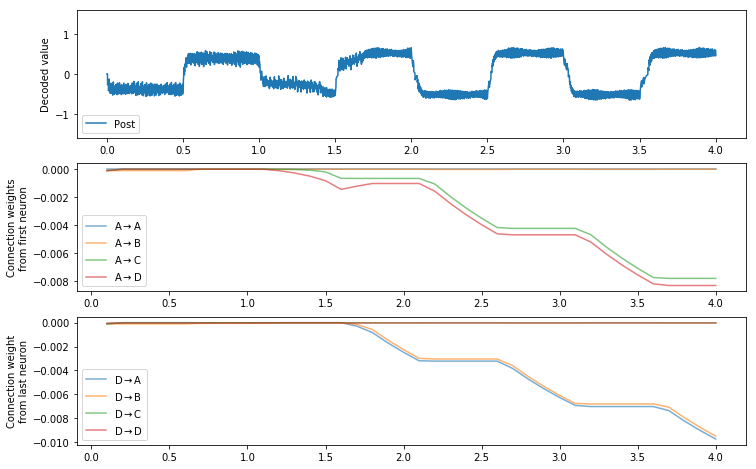

In [54]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

plt.subplot(3, 1, 2)
plt.plot(w_hist_trange, w_hist[:, 0], alpha=0.6)
plt.ylabel("Connection weights\nfrom first neuron")
plt.legend(rec_legend("A", ("A", "B", "C", "D")))

plt.subplot(3, 1, 3)
plt.plot(w_hist_trange, w_hist[:, -1], alpha=0.6)
plt.ylabel("Connection weight\nfrom last neuron")
plt.legend(rec_legend("D", ("A", "B", "C", "D")))

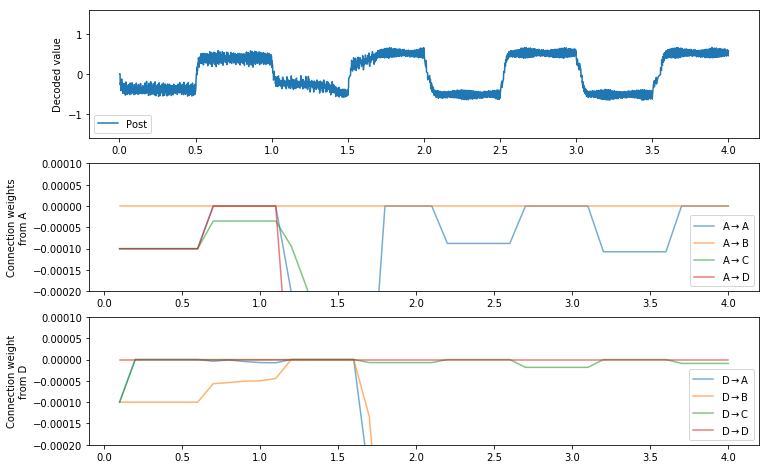

In [55]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

plt.subplot(3, 1, 2)
plt.plot(w_hist_trange, w_hist[:, 1], alpha=0.6)
plt.ylabel("Connection weights\nfrom A")
plt.ylim(-2e-4, 1e-4)
plt.legend(rec_legend("A", ("A", "B", "C", "D")))

plt.subplot(3, 1, 3)
plt.plot(w_hist_trange, w_hist[:, -1], alpha=0.6)
plt.ylabel("Connection weight\nfrom D")
plt.ylim(-2e-4, 1e-4)
plt.legend(rec_legend("D", ("A", "B", "C", "D")))

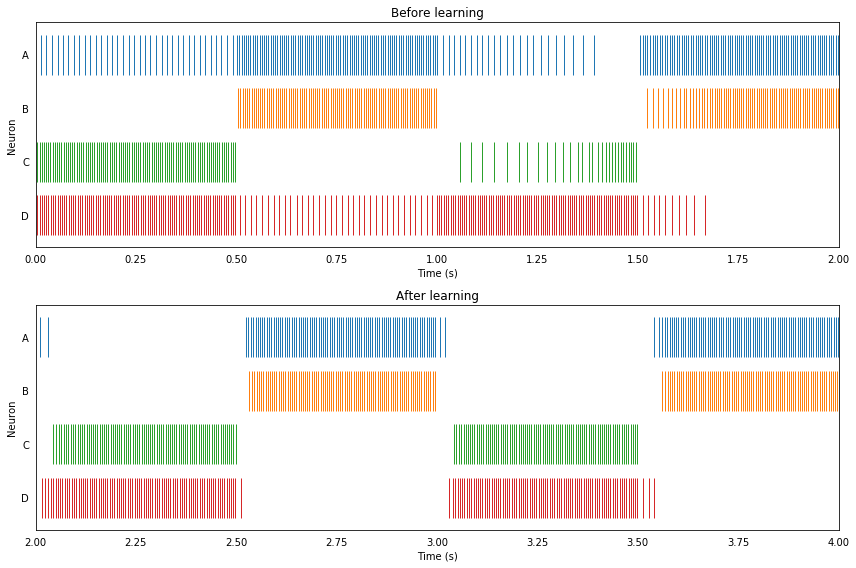

In [56]:
plt.figure(figsize=(12, 8))
win = int(2e3)

ax = plt.subplot(2, 1, 1)
rasterplot(sim.trange()[:win], sim.data[p_spikes][:win], ax)
ax.set_ylabel('Neuron')
ax.set_yticklabels(("A", "B", "C", "D"))
ax.set_xlabel('Time (s)')
ax.set_title('Before learning')

ax = plt.subplot(2, 1, 2)
rasterplot(sim.trange()[-win:], sim.data[p_spikes][-win:], ax)
ax.set_ylabel('Neuron')
ax.set_yticklabels(("A", "B", "C", "D"))
ax.set_xlabel('Time (s)')
ax.set_title('After learning')

plt.tight_layout()

# Apply Learning Control

Learning control does not remove the need for a lower learning rate and threshold.

In [69]:
def stim_func(t):
    if (t % 1) > 0.5:
        return 0.3
    else:
        return -0.3

def enabled_func(t):
    if 0.9 > (t % 1) > 0.6:
        return 1
    elif 0.4 > (t % 1) > 0.1:
        return 1
    else:
        return 0

In [70]:
with nengo.Network() as model:
    stim = nengo.Node(stim_func)
    enabled = nengo.Node(enabled_func)
    
    p_stim = nengo.Probe(stim)
    p_enabled = nengo.Probe(enabled)

with nengo.Simulator(model) as sim:
    sim.run(3.)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


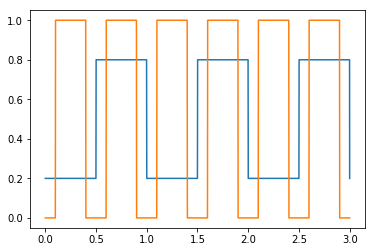

In [73]:
plt.plot(sim.trange(), sim.data[p_stim]+0.5)
plt.plot(sim.trange(), sim.data[p_enabled])

In [80]:
rec_inhib = (-1*np.ones(pre_nrn) + np.eye(pre_nrn)) / 1e4

with nengo.Network() as model:
    stim = nengo.Node(stim_func)
    enabled = nengo.Node(enabled_func)

    ens = nengo.Ensemble(pre_nrn, 1, **ens_params)

    rec_net = rec_bcm.RecBCM(pre_nrn, rec_inhib, learning_rate=5e-7, threshold=0., max_inhib=-0.02)

    nengo.Connection(stim, ens, synapse=None)

    nengo.Connection(ens.neurons, rec_net.in_neurons, synapse=0.01)
    nengo.Connection(ens.neurons, rec_net.out_neurons, synapse=0.01)
    nengo.Connection(enabled, rec_net.enable, synapse=None)
    nengo.Connection(rec_net.output, ens.neurons, synapse=None)

    p_in = nengo.Probe(stim)
    p_spikes = nengo.Probe(ens.neurons)
    p_out = nengo.Probe(ens, synapse=0.01)

In [81]:
sim_len = 4
with nengo.Simulator(model) as sim:
    sim.run(sim_len)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


In [82]:
w_hist = np.array(rec_net.weight_history)
w_hist_trange = sim.trange(dt=0.1)
print(w_hist.shape)
print(w_hist_trange.shape)

(40, 4, 4)
(40,)


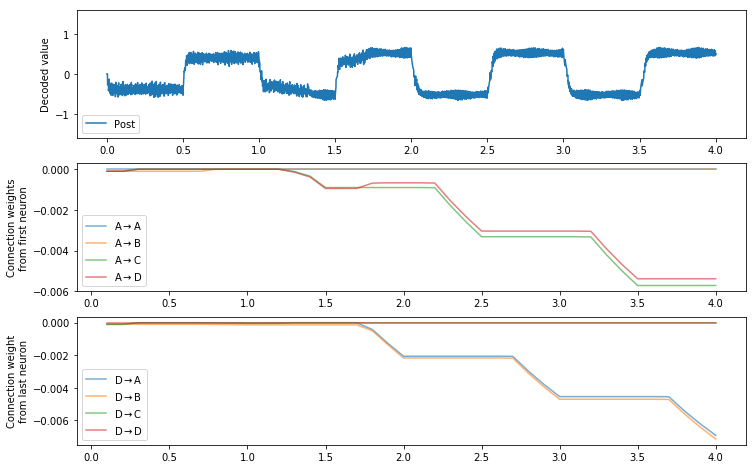

In [83]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

plt.subplot(3, 1, 2)
plt.plot(w_hist_trange, w_hist[:, 0], alpha=0.6)
plt.ylabel("Connection weights\nfrom first neuron")
plt.legend(rec_legend("A", ("A", "B", "C", "D")))

plt.subplot(3, 1, 3)
plt.plot(w_hist_trange, w_hist[:, -1], alpha=0.6)
plt.ylabel("Connection weight\nfrom last neuron")
plt.legend(rec_legend("D", ("A", "B", "C", "D")))

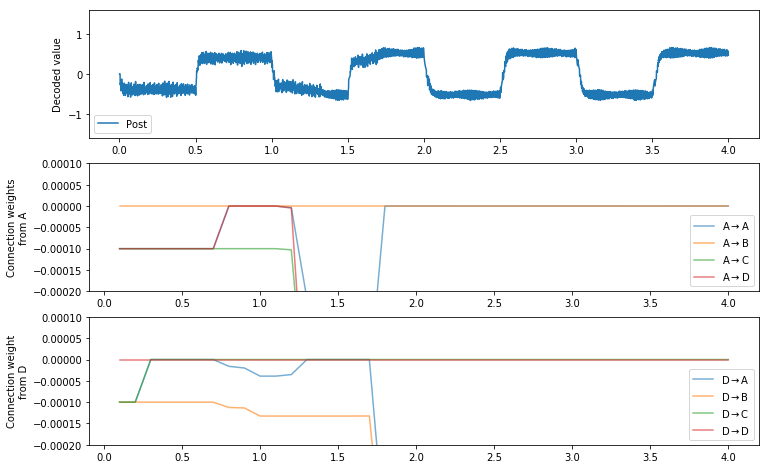

In [84]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

plt.subplot(3, 1, 2)
plt.plot(w_hist_trange, w_hist[:, 1], alpha=0.6)
plt.ylabel("Connection weights\nfrom A")
plt.ylim(-2e-4, 1e-4)
plt.legend(rec_legend("A", ("A", "B", "C", "D")))

plt.subplot(3, 1, 3)
plt.plot(w_hist_trange, w_hist[:, -1], alpha=0.6)
plt.ylabel("Connection weight\nfrom D")
plt.ylim(-2e-4, 1e-4)
plt.legend(rec_legend("D", ("A", "B", "C", "D")))

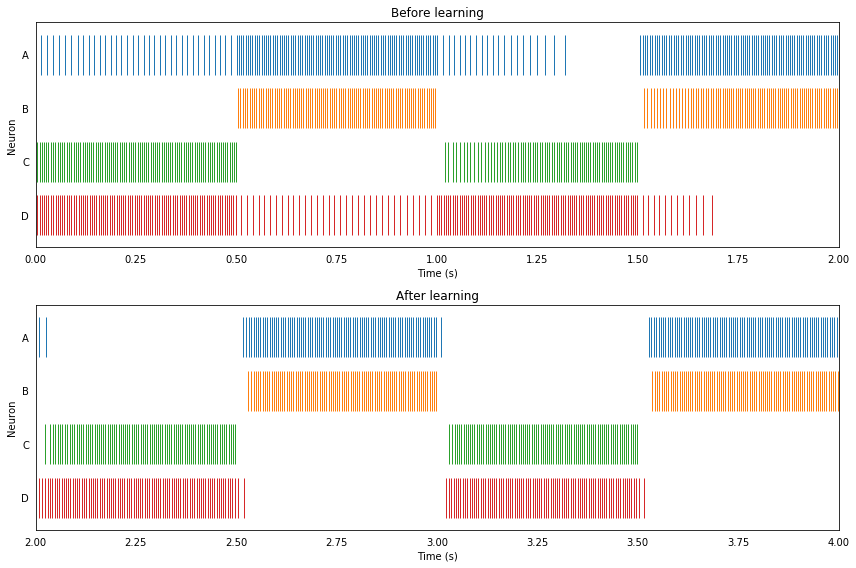

In [85]:
plt.figure(figsize=(12, 8))
win = int(2e3)

ax = plt.subplot(2, 1, 1)
rasterplot(sim.trange()[:win], sim.data[p_spikes][:win], ax)
ax.set_ylabel('Neuron')
ax.set_yticklabels(("A", "B", "C", "D"))
ax.set_xlabel('Time (s)')
ax.set_title('Before learning')

ax = plt.subplot(2, 1, 2)
rasterplot(sim.trange()[-win:], sim.data[p_spikes][-win:], ax)
ax.set_ylabel('Neuron')
ax.set_yticklabels(("A", "B", "C", "D"))
ax.set_xlabel('Time (s)')
ax.set_title('After learning')

plt.tight_layout()